# Long-Short Strategy, Part 1: Preparing Alpha Factors and Features

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. `preparing_the_model_data` (this noteboook): we'll engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [1]:
import warnings

from data.data_loader import data_loader
from utils import reduce_footprint

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
#START = '2010-01-01'
#END = '2021-05-01'

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]



## Loading Crypto Prices & Meta Data


In [7]:
suffix = 'xxxxx456'

print("w1")
downsampleshift = True
prices, metadata, categories = data_loader(timeframe='D',
                                           minutes_per_base_frequency=5,  # 5 Minutes sampled input data in data path
                prices_path='../data/crypto/prices_5Min.feather',
                min_observation_years=1,
                drop_level=True,
                exclude_stablecoins=True,
                cut=False,
                reduce_size=True,
                downsampleshift=True,
                d_shift=5,
                load_f32=True,
                join_sector=False,
                join_sectors=False)

print('prices dates {}:{}'.format(prices.index.get_level_values('date').min(),
                                 prices.index.get_level_values('date').max()))

w1
offset 0Min
offset 5Min
offset 10Min
offset 15Min
offset 20Min
offset 25Min
offset 30Min
offset 35Min
offset 40Min
offset 45Min
offset 50Min
offset 55Min
offset 60Min
offset 65Min
offset 70Min
offset 75Min
offset 80Min
offset 85Min
offset 90Min
offset 95Min
offset 100Min
offset 105Min
offset 110Min
offset 115Min
offset 120Min
offset 125Min
offset 130Min
offset 135Min
offset 140Min
offset 145Min
offset 150Min
offset 155Min
offset 160Min
offset 165Min
offset 170Min
offset 175Min
offset 180Min
offset 185Min
offset 190Min
offset 195Min
offset 200Min
offset 205Min
offset 210Min
offset 215Min
offset 220Min
offset 225Min
offset 230Min
offset 235Min
offset 240Min
offset 245Min
offset 250Min
offset 255Min
offset 260Min
offset 265Min
offset 270Min
offset 275Min
offset 280Min
offset 285Min
offset 290Min
offset 295Min
offset 300Min
offset 305Min
offset 310Min
offset 315Min
offset 320Min
offset 325Min
offset 330Min
offset 335Min
offset 340Min
offset 345Min
offset 350Min
offset 355Min
offset 360M

In [8]:
if downsampleshift:
    glevel= ['ticker', 'offset'] # no downsampleshift
else:
    glevel= 'ticker' # no downsampleshift

time_coefficient = 5 # 5 minute frequency but everything
# T = [1, 5, 10, 21, 42, 63]
T = [1, 2, 3, ]
T_minutes = T*time_coefficient
factor_scaling = 1

In [9]:
prices.close.groupby(level=['date']).count()

date
2013-03-31     286
2013-04-01     288
2013-04-02     288
2013-04-03     288
2013-04-04     288
              ... 
2021-06-19    8928
2021-06-20    8928
2021-06-21    8928
2021-06-22    8928
2021-06-23    5327
Name: close, Length: 3007, dtype: int64

In [10]:
prices.unstack(glevel).head()

open                                                   \
ticker         btc-usd ltc-usd eth-usd etc-usd zec-usd xmr-usd dash-usd   
offset            0       0       0       0       0       0        0      
date                                                                      
2013-03-31         NaN     NaN     NaN     NaN     NaN     NaN      NaN   
2013-04-01   93.250000     NaN     NaN     NaN     NaN     NaN      NaN   
2013-04-02  104.000000     NaN     NaN     NaN     NaN     NaN      NaN   
2013-04-03  117.958260     NaN     NaN     NaN     NaN     NaN      NaN   
2013-04-04  134.716553     NaN     NaN     NaN     NaN     NaN      NaN   

                                      ...  volume                            \
ticker     xrp-usd miota-usd eos-usd  ... bsv-usd btt-usd atom-usd wbtc-usd   
offset        0         0       0     ...    1435    1435     1435     1435   
date                                  ...                                     
2013-03-31     NaN       NaN     NaN  ...     NaN     NaN      NaN      NaN   
2013-04-01     NaN       NaN     NaN  ...     NaN     NaN      NaN      NaN   
2013-04-02     NaN       NaN     NaN  ...     NaN     NaN      NaN      NaN   
2013-04-03     NaN       NaN     NaN  ...     NaN     NaN      NaN      NaN   
2013-04-04     NaN       NaN     NaN  ...     NaN     NaN      NaN      NaN   

                                                             
ticker     leo-usd okb-usd algo-usd amp-usd ftt-usd chz-usd  
offset        1435    1435     1435    1435    1435    1435  
date                                                         
2013-03-31     NaN     NaN      NaN     NaN     NaN     NaN  
2013-04-01     NaN     NaN      NaN     NaN     NaN     NaN  
2013-04-02     NaN     NaN      NaN     NaN     NaN     NaN  
2013-04-03     NaN     NaN      NaN     NaN     NaN     NaN  
2013-04-04     NaN     NaN      NaN     NaN     NaN     NaN  

[5 rows x 46080 columns]

In [11]:
sadtfagdf = prices.unstack(glevel)

In [12]:
print('unique tickers {} \n{}'.format(prices.index.get_level_values('ticker').nunique(),
                                 prices.index.get_level_values('ticker').unique()))

unique tickers 32 
CategoricalIndex(['btc-usd', 'ltc-usd', 'eth-usd', 'etc-usd', 'zec-usd',
                  'xmr-usd', 'dash-usd', 'xrp-usd', 'miota-usd', 'eos-usd',
                  'neo-usd', 'qtum-usd', 'btg-usd', 'bat-usd', 'trx-usd',
                  'xlm-usd', 'mkr-usd', 'bnt-usd', 'vet-usd', 'xtz-usd',
                  'dgb-usd', 'enj-usd', 'bsv-usd', 'btt-usd', 'atom-usd',
                  'wbtc-usd', 'leo-usd', 'okb-usd', 'algo-usd', 'amp-usd',
                  'ftt-usd', 'chz-usd'],
                 categories=['btc-usd', 'ltc-usd', 'eth-usd', 'etc-usd', 'zec-usd', 'xmr-usd', 'dash-usd', 'xrp-usd', ...], ordered=False, name='ticker', dtype='category')


In [13]:
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11636124 entries, (Timestamp('2013-04-01 00:00:00'), 0, 'btc-usd') to (Timestamp('2021-06-22 00:00:00'), 1435, 'chz-usd')
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    11636124 non-null  float32
 1   high    11636124 non-null  float32
 2   low     11636124 non-null  float32
 3   close   11636124 non-null  float32
 4   volume  11636124 non-null  float64
dtypes: float32(4), float64(1)
memory usage: 333.0 MB


## Add some Basic Factors

See [appendix](../24_alpha_factor_library) for details on the below indicators.

### Compute the Relative Strength Index

In [14]:
prices['rsi'] = prices.groupby(level=glevel).close.apply(RSI)

print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))

In [15]:
prices['rsi']

date        offset  ticker  
2013-04-01  0       btc-usd           NaN
2013-04-02  0       btc-usd           NaN
2013-04-03  0       btc-usd           NaN
2013-04-04  0       btc-usd           NaN
2013-04-05  0       btc-usd           NaN
                                  ...    
2021-06-22  1435    leo-usd     47.748464
                    algo-usd    42.551112
                    amp-usd     48.783588
                    ftt-usd     37.919494
                    chz-usd     42.392286
Name: rsi, Length: 11636124, dtype: float64

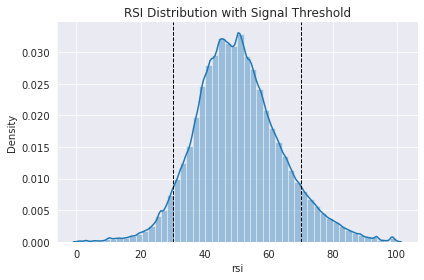

In [16]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

### Compute Bollinger Bands

In [17]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20*factor_scaling)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [18]:
prices = (prices.join(prices
                      .groupby(level=glevel)
                      .close
                      .apply(compute_bb)))


In [19]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

In [20]:
prices['bb_low'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
prices['bb_high'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))

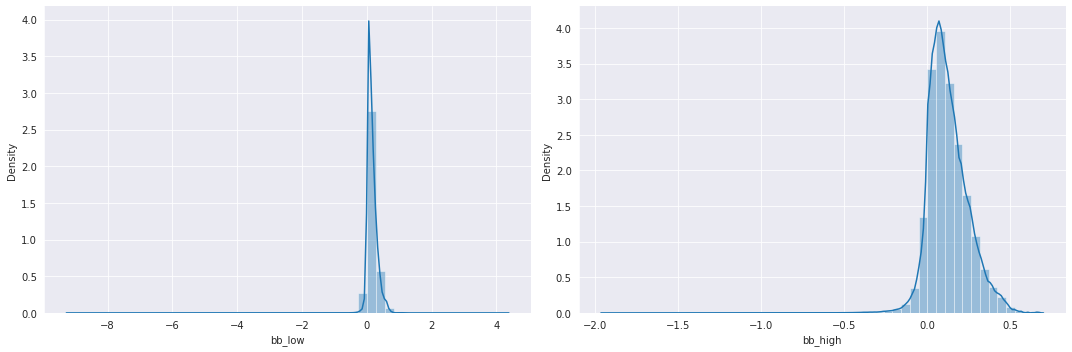

In [22]:
"""
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();
"""
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices['bb_low'].dropna(), ax=axes[0])
sns.distplot(prices['bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

### Compute Average True Range

In [23]:
prices['NATR'] = prices.groupby(level=glevel,
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))

In [ ]:
print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))

In [24]:
prices['NATR'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14*factor_scaling)
    return df.sub(df.mean()).div(df.std())


In [26]:
prices['ATR'] = (prices.groupby(glevel, group_keys=False)
                 .apply(compute_atr))
prices['ATR'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))

### Compute Moving Average Convergence/Divergence

In [27]:
prices['PPO'] = prices.groupby(level=glevel).close.apply(talib.PPO)
prices['PPO'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)


In [29]:
prices['MACD'] = (prices
                  .groupby(glevel, group_keys=False)
                  .close
                  .apply(compute_macd))

In [30]:
prices['MACD']

date        offset  ticker  
2013-04-01  0       btc-usd          NaN
2013-04-02  0       btc-usd          NaN
2013-04-03  0       btc-usd          NaN
2013-04-04  0       btc-usd          NaN
2013-04-05  0       btc-usd          NaN
                                  ...   
2021-06-22  1435    leo-usd    -0.520373
                    algo-usd   -1.016905
                    amp-usd    -0.025172
                    ftt-usd    -2.087099
                    chz-usd    -0.829525
Name: MACD, Length: 11636124, dtype: float64

### Combine Price and Meta Data

In [31]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

In [32]:
prices['sector'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute Returns

### Historical Returns

In [33]:
by_sym = prices.groupby(level=glevel).close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

t=1
prices[f'r{t:02}'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,0.139125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,0.148044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,-0.020045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-05,0.076108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-06,0.007067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-07,0.141489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Daily historical return deciles

In [34]:
for t in T:
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}']
                             .groupby(level='date')
                             .apply(lambda x: pd.qcut(x, 
                                                      q=3,
                                                      labels=False, 
                                                      duplicates='drop')))
prices[f'r{t:02}dec'].unstack(glevel)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-19,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,0.0,1.0,2.0,2.0,NaN,1.0,2.0,2.0,2.0
2021-06-20,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,2.0,2.0,NaN,0.0,2.0,1.0,0.0


### Daily sector return deciles

In [35]:
for t in T:
    prices[f'r{t:02}q_sector'] = (prices
                                  .groupby(['date', 'sector'])[f'r{t:02}']
                                  .transform(lambda x: pd.qcut(x, 
                                                               q=3,
                                                               labels=False, 
                                                               duplicates='drop')))

In [36]:
prices[f'r{t:02}q_sector'].unstack(glevel)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
offset,0,0,0,0,0,0,0,0,0,0,...,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
date,,,,,,,,,,,,,,,,,,,,,
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-04,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-19,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2.0,2.0,NaN,1.0,2.0,2.0,1.0
2021-06-20,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,0.0,0.0,0.0,2.0,2.0,NaN,0.0,2.0,1.0,0.0


### Compute Forward Returns

In [37]:
for t in T:
    prices[f'r{t:02}_fwd'] = prices.groupby(level=glevel)[f'r{t:02}'].shift(-t)

prices[f'r{t:02}_fwd']

date        offset  ticker  
2013-04-01  0       btc-usd     0.281553
2013-04-02  0       btc-usd     0.210655
2013-04-03  0       btc-usd     0.061990
2013-04-04  0       btc-usd     0.237045
2013-04-05  0       btc-usd     0.316368
                                  ...   
2021-06-22  1435    leo-usd          NaN
                    algo-usd         NaN
                    amp-usd          NaN
                    ftt-usd          NaN
                    chz-usd          NaN
Name: r03_fwd, Length: 11636124, dtype: float32

## Remove outliers

In [38]:
prices[[f'r{t:02}' for t in T]].describe(percentiles=percentiles)

,r01,r02,r03
count,1.162691e+07,1.161769e+07,1.160848e+07
mean,3.780307e-03,7.005853e-03,1.027192e-02
std,7.969180e-02,1.077126e-01,1.315013e-01
min,-9.590698e-01,-9.748542e-01,-9.629861e-01
0.1%,-3.607582e-01,-4.254912e-01,-4.761891e-01
1%,-1.863466e-01,-2.390254e-01,-2.784992e-01
2%,-1.472024e-01,-1.907653e-01,-2.229412e-01
3%,-1.257785e-01,-1.651490e-01,-1.943493e-01
4%,-1.106104e-01,-1.471698e-01,-1.749604e-01
5%,-9.914416e-02,-1.336010e-01,-1.600878e-01


We remove daily returns above 100 percent as these are more likely to represent data errors; we are using the 100 percent cutoff here in a somewhat ad-hoc fashion; you would want to apply more careful exploratory and historical analysis to decide which assets are truly not representative of the sample period.

In [39]:
#outliers = prices[prices.r01 > 1].index.get_level_values(glevel).unique()

In [40]:
#prices = prices.drop(outliers, level=glevel)

## Create time and sector dummy variables

In [41]:
prices['year'] = prices.index.get_level_values('date').year.astype('int16')
prices['month'] = prices.index.get_level_values('date').month.astype('int16')
prices['weekday'] = prices.index.get_level_values('date').weekday.astype('int16')

## Store Model Data

In [42]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11636124 entries, (Timestamp('2013-04-01 00:00:00'), 0, 'btc-usd') to (Timestamp('2021-06-22 00:00:00'), 1435, 'chz-usd')
Data columns (total 28 columns):
 #   Column       Dtype  
---  ------       -----  
 0   open         float32
 1   high         float32
 2   low          float32
 3   close        float32
 4   volume       float64
 5   rsi          float64
 6   bb_high      float64
 7   bb_low       float64
 8   NATR         float64
 9   ATR          float64
 10  PPO          float64
 11  MACD         float64
 12  sector       int64  
 13  r01          float32
 14  r02          float32
 15  r03          float32
 16  r01dec       float64
 17  r02dec       float64
 18  r03dec       float64
 19  r01q_sector  float32
 20  r02q_sector  float32
 21  r03q_sector  float32
 22  r01_fwd      float32
 23  r02_fwd      float32
 24  r03_fwd      float32
 25  year         int64  
 26  month        int64  
 27  weekday      int64  
dtypes: float32

In [43]:
prices.unstack(['ticker'])

open                                                  \
ticker              btc-usd     ltc-usd      eth-usd    etc-usd     zec-usd   
date       offset                                                             
2013-03-31 10         93.25         NaN          NaN        NaN         NaN   
           15         93.25         NaN          NaN        NaN         NaN   
           20         93.25         NaN          NaN        NaN         NaN   
           25         93.25         NaN          NaN        NaN         NaN   
           30         93.25         NaN          NaN        NaN         NaN   
...                     ...         ...          ...        ...         ...   
2021-06-23 850     33980.00  128.539993  1987.300049  40.712002  112.300003   
           855          NaN         NaN  1986.900024        NaN  112.099998   
           860          NaN         NaN          NaN        NaN         NaN   
           865          NaN         NaN          NaN        NaN         NaN   
           870          NaN         NaN          NaN        NaN         NaN   

                                                                      ...  \
ticker                xmr-usd    dash-usd  xrp-usd miota-usd eos-usd  ...   
date       offset                                                     ...   
2013-03-31 10             NaN         NaN      NaN       NaN     NaN  ...   
           15             NaN         NaN      NaN       NaN     NaN  ...   
           20             NaN         NaN      NaN       NaN     NaN  ...   
           25             NaN         NaN      NaN       NaN     NaN  ...   
           30             NaN         NaN      NaN       NaN     NaN  ...   
...                       ...         ...      ...       ...     ...  ...   
2021-06-23 850     214.880005  126.809998  0.63469   0.79357  3.6708  ...   
           855     215.009995  126.860001  0.63562   0.79637  3.6737  ...   
           860            NaN         NaN      NaN       NaN     NaN  ...   
           865            NaN         NaN      NaN       NaN     NaN  ...   
           870            NaN         NaN      NaN       NaN     NaN  ...   

                  weekday                                                     \
ticker            bsv-usd btt-usd atom-usd wbtc-usd leo-usd okb-usd algo-usd   
date       offset                                                              
2013-03-31 10         NaN     NaN      NaN      NaN     NaN     NaN      NaN   
           15         NaN     NaN      NaN      NaN     NaN     NaN      NaN   
           20         NaN     NaN      NaN      NaN     NaN     NaN      NaN   
           25         NaN     NaN      NaN      NaN     NaN     NaN      NaN   
           30         NaN     NaN      NaN      NaN     NaN     NaN      NaN   
...                   ...     ...      ...      ...     ...     ...      ...   
2021-06-23 850        2.0     2.0      2.0      2.0     2.0     NaN      2.0   
           855        2.0     2.0      2.0      2.0     2.0     NaN      2.0   
           860        2.0     2.0      2.0      2.0     2.0     NaN      2.0   
           865        2.0     2.0      2.0      2.0     2.0     NaN      2.0   
           870        NaN     NaN      NaN      2.0     2.0     NaN      2.0   

                                           
ticker            amp-usd ftt-usd chz-usd  
date       offset                          
2013-03-31 10         NaN     NaN     NaN  
           15         NaN     NaN     NaN  
           20         NaN     NaN     NaN  
           25         NaN     NaN     NaN  
           30         NaN     NaN     NaN  
...                   ...     ...     ...  
2021-06-23 850        2.0     NaN     2.0  
           855        2.0     NaN     2.0  
           860        2.0     NaN     2.0  
           865        2.0     NaN     2.0  
           870        NaN     NaN     2.0  

[865901 rows x 896 columns]

In [44]:
prices_small = reduce_footprint(prices.dropna(), except_cols=['volume'])
inf = prices_small.index[np.isinf(prices_small).any(1)]
nan = prices_small.index[np.isnan(prices_small).any(1)]

inf, nan

(MultiIndex([], names=['date', 'offset', 'ticker']),
 MultiIndex([], names=['date', 'offset', 'ticker']))

In [45]:
prices_small.sort_index(inplace=True)
prices_small.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).reset_index().to_feather('data.feather' + suffix)
prices_small[['open', 'close', 'low', 'high', 'volume']].reset_index().to_feather('prices.feather' + suffix)
prices_small.reset_index().to_feather('data+prices.feather' + suffix)

prices_small.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11211158 entries, (Timestamp('2013-05-03 00:00:00'), 10, 'btc-usd') to (Timestamp('2021-06-20 00:00:00'), 870, 'wbtc-usd')
Data columns (total 28 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         11211158 non-null  float32
 1   high         11211158 non-null  float32
 2   low          11211158 non-null  float32
 3   close        11211158 non-null  float32
 4   volume       11211158 non-null  float64
 5   rsi          11211158 non-null  float32
 6   bb_high      11211158 non-null  float32
 7   bb_low       11211158 non-null  float32
 8   NATR         11211158 non-null  float32
 9   ATR          11211158 non-null  float32
 10  PPO          11211158 non-null  float32
 11  MACD         11211158 non-null  float32
 12  sector       11211158 non-null  int16  
 13  r01          11211158 non-null  float32
 14  r02          11211158 non-null  float32
 15  r03          11211158 no

In [46]:
prices.resample('M')


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'